# DOWNLOADING


In [4]:
import os
import requests
from tqdm import tqdm

def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # Create directory if it doesn't exist

    # Get the file name from the URL
    file_name = os.path.join(dest_folder, url.split('/')[-1])

    # Check if the file already exists
    if os.path.exists(file_name):
        # Get the size of the file already downloaded
        resume_header = {'Range': 'bytes=%d-' % os.path.getsize(file_name)}
        r = requests.get(url, headers=resume_header, stream=True)
        total_size = int(r.headers.get('content-length', 0)) + os.path.getsize(file_name)
        mode = 'ab'  # Append mode
    else:
        r = requests.get(url, stream=True)
        total_size = int(r.headers.get('content-length', 0))
        mode = 'wb'  # Write mode

    with open(file_name, mode) as f:
        pbar = tqdm(total=total_size, initial=os.path.getsize(file_name), unit='B', unit_scale=True, desc=file_name)
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:  # Filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(len(chunk))
        pbar.close()

    print(f"Download completed: {file_name}")

# Define the URLs and destination folder
urls = [
    "http://www.openslr.org/resources/12/dev-clean.tar.gz",
    "http://www.openslr.org/resources/12/train-clean-100.tar.gz",
    "http://www.openslr.org/resources/12/test-clean.tar.gz"
]

# Change the destination folder to your desired location
dest_folder = r"T:\paper dataset"  # Use raw string to handle backslashes

# Download each file
for url in urls:
    download_file(url, dest_folder)


T:\paper dataset\dev-clean.tar.gz: 338MB [00:00, ?B/s]                                                                 


Download completed: T:\paper dataset\dev-clean.tar.gz


T:\paper dataset\train-clean-100.tar.gz: 6.39GB [00:00, ?B/s]                                                          


Download completed: T:\paper dataset\train-clean-100.tar.gz


T:\paper dataset\test-clean.tar.gz: 347MB [00:00, ?B/s]                                                                

Download completed: T:\paper dataset\test-clean.tar.gz


# SQLITE

In [1]:
import sqlite3
import re

# Database setup
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Database path
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Step 1: Database and table creation (completed as before)
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

    # Define tables for books, speakers, and chapters
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS books (
            book_id INTEGER PRIMARY KEY,
            book_name TEXT
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS speakers (
            reader_id INTEGER PRIMARY KEY,
            gender TEXT,
            subset TEXT,
            duration REAL,  -- changed to REAL to accept floating-point values
            name TEXT
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS chapters (
            chapter_id TEXT PRIMARY KEY,
            reader_id INTEGER,
            duration REAL,  -- changed to REAL to accept floating-point values
            subset TEXT,
            project_id INTEGER,
            book_id INTEGER,
            chapter_title TEXT,
            project_title TEXT,
            FOREIGN KEY (reader_id) REFERENCES speakers(reader_id),
            FOREIGN KEY (book_id) REFERENCES books(book_id)
        )
    ''')

    conn.commit()


In [2]:
# Step 2: Insert data from books.txt with error handling for extra information
with open('books.txt', 'r') as file:
    for line in file:
        if line.strip() and not line.startswith(";"):  # Ignore empty lines and comments
            try:
                # Only split on the first '|' to handle cases with extra details after book_name
                book_id, book_name = line.split('|', 1)
                cursor.execute("INSERT OR IGNORE INTO books (book_id, book_name) VALUES (?, ?)",
                               (int(book_id.strip()), book_name.split('|')[0].strip()))
            except ValueError as e:
                print(f"Skipping line in books.txt due to error: {line.strip()} - {e}")


# Step 3: Insert data from speakers.txt
with open('speakers.txt', 'r') as file:
    for line in file:
        if line.strip() and not line.startswith(";"):
            fields = line.split('|')
            if len(fields) >= 5:  # Ensure there are enough fields
                reader_id, gender, subset, duration, name = fields[:5]
                try:
                    cursor.execute("INSERT OR IGNORE INTO speakers (reader_id, gender, subset, duration, name) VALUES (?, ?, ?, ?, ?)",
                                   (int(reader_id.strip()), gender.strip(), subset.strip(), float(duration.strip()), name.strip()))
                except ValueError as e:
                    print(f"Skipping line in speakers.txt due to error: {line.strip()} - {e}")
            else:
                print(f"Skipping line in speakers.txt due to format issue: {line.strip()}")

# Step 4: Insert data from chapters.txt
with open('chapters.txt', 'r') as file:
    for line in file:
        if line.strip() and not line.startswith(";"):
            fields = line.split('|')
            if len(fields) >= 8:  # Ensure there are enough fields
                chapter_id, reader_id, duration, subset, project_id, book_id, chapter_title, project_title = fields[:8]
                try:
                    cursor.execute('''INSERT OR IGNORE INTO chapters 
                                      (chapter_id, reader_id, duration, subset, project_id, book_id, chapter_title, project_title) 
                                      VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
                                   (int(chapter_id.strip()), int(reader_id.strip()), float(duration.strip()), subset.strip(),
                                    int(project_id.strip()), int(book_id.strip()), chapter_title.strip(), project_title.strip()))
                except ValueError as e:
                    print(f"Skipping line in chapters.txt due to error: {line.strip()} - {e}")
            else:
                print(f"Skipping line in chapters.txt due to format issue: {line.strip()}")

# Commit and close the database
conn.commit()
print("Data inserted successfully.")
conn.close()

Skipping line in books.txt due to error: book_id| book_name                                          | - invalid literal for int() with base 10: 'book_id'
Skipping line in books.txt due to error: Apocrypha     | - invalid literal for int() with base 10: 'Apocrypha'
Skipping line in books.txt due to error: California, Utah, Nevada, Washington, Oregon, the Grand Canyon | - invalid literal for int() with base 10: 'California, Utah, Nevada, Washington, Oregon, the Grand Canyon'
Skipping line in books.txt due to error: Sparks from War Eagle's Lodge-Fire | Frank Bird Linderman - invalid literal for int() with base 10: "Sparks from War Eagle's Lodge-Fire"
Skipping line in books.txt due to error: a Simple Tale                    | - invalid literal for int() with base 10: 'a Simple Tale'
Skipping line in books.txt due to error: (Sometimes Called The Child of the Cavern) | - invalid literal for int() with base 10: '(Sometimes Called The Child of the Cavern)'
Skipping line in books.txt due to er

In [1]:
import sqlite3

# Define the database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Function to display table data
def display_table_data(table_name, limit=10):
    print(f"\nData from {table_name} table:")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT {limit}")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

# Get and print all table names
print("Tables in the database:")
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(table[0])

# Check and display content from `books`, `speakers`, and `chapters` tables
for table in ['books', 'speakers', 'chapters']:
    display_table_data(table)

# Close the connection
conn.close()


Tables in the database:
books
speakers
chapters

Data from books table:
(1, 'United States Declaration of Independence          |')
(11, "Alice's Adventures in Wonderland                   |")
(12, 'Through the Looking-Glass                          |')
(13, 'The Hunting of the Snark                           |')
(16, 'Peter Pan                                          |')
(17, 'The Book of Mormon                                 |  Church of Jesus Christ of Latter-day Saints, Joseph, Jr. Smith, Joseph Smith')
(20, 'Paradise Lost                                      |')
(23, 'Narrative of the Life of Frederick Douglass, an American Slave | Frederick Douglass, Frederick Augustus Washington Bailey, Frederick Augustus Washington Baly')
(24, 'O Pioneers!                                        |')
(32, 'Herland                                            |')

Data from speakers table:
(14, 'F', 'train-clean-360', 25.03, 'Kristin LeMoine')
(16, 'F', 'train-clean-360', 25.11, 'Alys AtteWater')


In [3]:
import sqlite3
import re

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Adjust as necessary

# Recreate the books table with author column
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute("DROP TABLE IF EXISTS books")
    cursor.execute("""
        CREATE TABLE books (
            book_id INTEGER PRIMARY KEY,
            book_name TEXT NOT NULL,
            author TEXT
        )
    """)
    conn.commit()

# Helper function to clean up and parse each entry
def parse_line(line):
    parts = line.strip().split("|")
    if len(parts) < 2:
        return None  # Skip malformed lines
    try:
        book_id = int(parts[0].strip())  # Ensure book_id is an integer
        book_name = parts[1].strip()
        author = parts[2].strip() if len(parts) > 2 else None
        return (book_id, book_name, author)
    except ValueError:
        return None

# Process books.txt with handling for multiline entries
with open('books.txt', 'r') as file:
    buffer = ""
    for line in file:
        # Check for new line starting with a possible book_id (number and pipe)
        if re.match(r"^\d+\s+\|", line):
            # Process any buffered entry before starting a new one
            if buffer:
                parsed_entry = parse_line(buffer)
                if parsed_entry:
                    with sqlite3.connect(db_path) as conn:
                        cursor = conn.cursor()
                        cursor.execute("INSERT INTO books (book_id, book_name, author) VALUES (?, ?, ?)", parsed_entry)
                        conn.commit()
            # Reset buffer to start new entry
            buffer = line.strip()
        else:
            # Continue adding to the buffer for multiline entries
            buffer += " " + line.strip()

    # Process the last buffered entry
    if buffer:
        parsed_entry = parse_line(buffer)
        if parsed_entry:
            with sqlite3.connect(db_path) as conn:
                cursor = conn.cursor()
                cursor.execute("INSERT INTO books (book_id, book_name, author) VALUES (?, ?, ?)", parsed_entry)
                conn.commit()


In [4]:
import sqlite3

# Define the database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Function to display table data
def display_table_data(table_name, limit=10):
    print(f"\nData from {table_name} table:")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT {limit}")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

# Get and print all table names
print("Tables in the database:")
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(table[0])

# Check and display content from `books`, `speakers`, and `chapters` tables
for table in ['books', 'speakers', 'chapters']:
    display_table_data(table)

# Close the connection
conn.close()


Tables in the database:
speakers
chapters
books

Data from books table:
(1, 'United States Declaration of Independence', '')
(11, "Alice's Adventures in Wonderland", '')
(12, 'Through the Looking-Glass', '')
(13, 'The Hunting of the Snark', '')
(16, 'Peter Pan', '')
(17, 'The Book of Mormon', 'Church of Jesus Christ of Latter-day Saints, Joseph, Jr. Smith, Joseph Smith')
(20, 'Paradise Lost', '')
(23, 'Narrative of the Life of Frederick Douglass, an American Slave', 'Frederick Douglass, Frederick Augustus Washington Bailey, Frederick Augustus Washington Baly')
(24, 'O Pioneers!', '')
(32, 'Herland', '')

Data from speakers table:
(14, 'F', 'train-clean-360', 25.03, 'Kristin LeMoine')
(16, 'F', 'train-clean-360', 25.11, 'Alys AtteWater')
(17, 'M', 'train-clean-360', 25.04, 'Gord Mackenzie')
(19, 'F', 'train-clean-100', 25.19, 'Kara Shallenberg')
(20, 'F', 'train-other-500', 30.07, 'Gesine')
(22, 'F', 'train-clean-360', 25.14, 'Michelle Crandall')
(23, 'F', 'train-clean-360', 25.23, 'Ani

In [5]:
import sqlite3

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Adjust the path as necessary

# Connect to the database and retrieve all data from the books table
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM books")
    books_data = cursor.fetchall()

# Print each row in the books table
for row in books_data:
    print(row)


(1, 'United States Declaration of Independence', '')
(11, "Alice's Adventures in Wonderland", '')
(12, 'Through the Looking-Glass', '')
(13, 'The Hunting of the Snark', '')
(16, 'Peter Pan', '')
(17, 'The Book of Mormon', 'Church of Jesus Christ of Latter-day Saints, Joseph, Jr. Smith, Joseph Smith')
(20, 'Paradise Lost', '')
(23, 'Narrative of the Life of Frederick Douglass, an American Slave', 'Frederick Douglass, Frederick Augustus Washington Bailey, Frederick Augustus Washington Baly')
(24, 'O Pioneers!', '')
(32, 'Herland', '')
(33, 'The Scarlet Letter', '')
(35, 'The Time Machine', '')
(36, 'The War of the Worlds', '')
(44, 'The Song of the Lark', '')
(45, 'Anne of Green Gables', '')
(46, 'A Christmas Carol in Prose; Being a Ghost Story of Christmas', '')
(47, 'Anne of Avonlea', '')
(51, 'Anne of the Island', '')
(54, 'The Marvelous Land of Oz', '')
(55, 'The Wonderful Wizard of Oz', '')
(58, 'Paradise Regained', '')
(59, "Discourse on the Method of Rightly Conducting One's Reaso

# SQL Command: Add Fields to Chapters Table


In [1]:
import sqlite3

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the database and add columns
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    
    # Add audio_path and transcript_path fields to chapters table if not exists
    cursor.execute("ALTER TABLE chapters ADD COLUMN audio_path TEXT")
    cursor.execute("ALTER TABLE chapters ADD COLUMN transcript_path TEXT")
    
    conn.commit()


# 
directory traversal

In [3]:
import os
import sqlite3

# Paths to each subset directory
base_paths = {
    'train-clean-100': r"T:\paper dataset\train-clean-100\LibriSpeech\train-clean-100",
    'dev-clean': r"T:\paper dataset\dev-clean\LibriSpeech\dev-clean",
    'test-clean': r"T:\paper dataset\test-clean\LibriSpeech\test-clean"
}

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the database
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    
    # Traverse each subset directory
    for subset_name, base_path in base_paths.items():
        for reader_id in os.listdir(base_path):  # Using reader_id as per database
            reader_path = os.path.join(base_path, reader_id)
            
            if os.path.isdir(reader_path):  # Check if reader_path is a directory
                for chapter_id in os.listdir(reader_path):
                    chapter_path = os.path.join(reader_path, chapter_id)
                    
                    # Check if chapter_path is a directory and contains .trans.txt
                    if os.path.isdir(chapter_path):
                        transcript_file = f"{reader_id}-{chapter_id}.trans.txt"
                        transcript_path = os.path.join(chapter_path, transcript_file)
                        
                        # Collect all .flac file paths in this chapter directory
                        audio_paths = [
                            os.path.join(chapter_path, file)
                            for file in os.listdir(chapter_path)
                            if file.endswith('.flac')
                        ]
                        
                        # Update the database for each chapter
                        cursor.execute('''
                            UPDATE chapters
                            SET audio_path = ?, transcript_path = ?
                            WHERE reader_id = ? AND chapter_id = ?
                        ''', (str(audio_paths), transcript_path, reader_id, chapter_id))
    
    # Commit the changes after all paths have been updated
    conn.commit()


#   
verification

In [10]:
# Fetch and display some sample records to verify audio and transcript paths
sample_query = '''
    SELECT reader_id, chapter_id, audio_path, transcript_path
    FROM chapters
    LIMIT 5
'''

with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute(sample_query)
    samples = cursor.fetchall()

# Print out sample records
for sample in samples:
    print("Reader ID:", sample[0])
    print("Chapter ID:", sample[1])
    print("Audio Path:", sample[2])
    print("Transcript Path:", sample[3])
    print("-" * 50)


Reader ID: 110
Chapter ID: 1
Audio Path: None
Transcript Path: None
--------------------------------------------------
Reader ID: 110
Chapter ID: 2
Audio Path: None
Transcript Path: None
--------------------------------------------------
Reader ID: 4174
Chapter ID: 159
Audio Path: None
Transcript Path: None
--------------------------------------------------
Reader ID: 19
Chapter ID: 198
Audio Path: ['T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0000.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0001.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0002.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0003.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0004.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0005.flac', 'T:\\paper dataset\\train-c

# 
meta data whole librie speech corpus we only taking train 100 so we are filtering

In [13]:
import os
import sqlite3

# Paths to each subset directory
base_paths = {
    'train-clean-100': r"T:\paper dataset\train-clean-100\LibriSpeech\train-clean-100",
    'dev-clean': r"T:\paper dataset\dev-clean\LibriSpeech\dev-clean",
    'test-clean': r"T:\paper dataset\test-clean\LibriSpeech\test-clean"
}

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Step 1: Collect all relevant reader_ids present in the subset directories
valid_reader_ids = set()

for subset_name, base_path in base_paths.items():
    for reader_id in os.listdir(base_path):
        reader_path = os.path.join(base_path, reader_id)
        if os.path.isdir(reader_path):  # Confirm that it's a directory (a valid reader)
            valid_reader_ids.add(int(reader_id))  # Convert reader_id to int for consistency with database schema

# Step 2: Connect to the database and filter records
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    
    # Convert valid_reader_ids set to a tuple
    valid_reader_ids_tuple = tuple(valid_reader_ids)
    
    if valid_reader_ids_tuple:
        # Construct the SQL query string with placeholders for each reader_id
        placeholders = ', '.join(['?'] * len(valid_reader_ids_tuple))
        
        # Delete records for readers not present in valid_reader_ids
        cursor.execute(f"DELETE FROM chapters WHERE reader_id NOT IN ({placeholders})", valid_reader_ids_tuple)
        cursor.execute(f"DELETE FROM speakers WHERE reader_id NOT IN ({placeholders})", valid_reader_ids_tuple)
        
        # Commit changes to remove non-relevant entries
        conn.commit()
    
        # Optional: Check the remaining reader count in the database
        cursor.execute("SELECT COUNT(*) FROM speakers")
        remaining_readers = cursor.fetchone()[0]
        print(f"Remaining readers after filtering: {remaining_readers}")
    else:
        print("No valid reader IDs found in the provided directories.")


Remaining readers after filtering: 331


In [15]:
# Fetch and display some sample records to verify audio and transcript paths
sample_query = '''
    SELECT reader_id, chapter_id, audio_path, transcript_path
    FROM chapters
    LIMIT 5
'''

with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute(sample_query)
    samples = cursor.fetchall()

# Print out sample records
for sample in samples:
    print("Reader ID:", sample[0])
    print("Chapter ID:", sample[1])
    print("Audio Path:", sample[2])
    print("Transcript Path:", sample[3])
    print("-" * 50)


Reader ID: 19
Chapter ID: 198
Audio Path: ['T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0000.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0001.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0002.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0003.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0004.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0005.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0006.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0007.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0008.flac', 'T:\\paper dataset\\train-clean-100\\LibriSpeech\\train-clean-100\\19\\198\\19-198-0009.flac', 'T:\\pa

In [17]:


# Execute a query to retrieve column names
cursor.execute('SELECT * FROM books LIMIT 1;')
column_names = [description[0] for description in cursor.description]

# Print column names
print(column_names)




['book_id', 'book_name', 'author']


In [7]:

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
# Execute a query to retrieve column names
cursor.execute('SELECT * FROM speakers LIMIT 1;')
column_names = [description[0] for description in cursor.description]

# Print column names
print(column_names)



['reader_id', 'gender', 'subset', 'duration', 'name']


In [5]:

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
# Execute a query to retrieve column names
cursor.execute('SELECT * FROM utterances LIMIT 1;')
column_names = [description[0] for description in cursor.description]

# Print column names
print(column_names)



['utterance_id', 'speaker_id', 'chapter_id', 'file_path', 'transcript']


In [20]:

# Execute a query to retrieve column names
cursor.execute('SELECT * FROM chapters LIMIT 1;')
column_names = [description[0] for description in cursor.description]

# Print column names
print(column_names)



['chapter_id', 'reader_id', 'duration', 'subset', 'project_id', 'book_id', 'chapter_title', 'project_title', 'audio_path', 'transcript_path']


In [5]:
import sqlite3
import os

# Define paths
base_paths = {
    'train-clean-100': r"T:\paper dataset\train-clean-100\LibriSpeech\train-clean-100",
    'dev-clean': r"T:\paper dataset\dev-clean\LibriSpeech\dev-clean",
    'test-clean': r"T:\paper dataset\test-clean\LibriSpeech\test-clean"
}
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Define the SQL command to create the `utterances` table if it doesn't exist
create_utterances_table = """
CREATE TABLE IF NOT EXISTS utterances (
    utterance_id TEXT PRIMARY KEY,
    speaker_id INTEGER,
    chapter_id INTEGER,
    file_path TEXT,
    transcript TEXT,
    FOREIGN KEY(speaker_id) REFERENCES speakers(reader_id),
    FOREIGN KEY(chapter_id) REFERENCES chapters(chapter_id)
);
"""
cursor.execute(create_utterances_table)
conn.commit()

# Function to parse and insert data into the `utterances` table
def populate_utterances_table():
    for subset, base_path in base_paths.items():
        # Iterate through each speaker directory
        for speaker_id in os.listdir(base_path):
            speaker_path = os.path.join(base_path, speaker_id)
            if not os.path.isdir(speaker_path):
                continue

            # Iterate through each chapter directory
            for chapter_id in os.listdir(speaker_path):
                chapter_path = os.path.join(speaker_path, chapter_id)
                if not os.path.isdir(chapter_path):
                    continue

                # Path to the transcript file
                transcript_path = os.path.join(chapter_path, f"{speaker_id}-{chapter_id}.trans.txt")

                # Parse the trans.txt file
                if os.path.exists(transcript_path):
                    with open(transcript_path, 'r', encoding='utf-8') as file:
                        for line in file:
                            # Each line format: <utterance_id> <transcript>
                            parts = line.strip().split(" ", 1)
                            if len(parts) < 2:
                                continue
                            utterance_id, transcript = parts
                            
                            # File path for the .flac file
                            file_path = os.path.join(chapter_path, f"{utterance_id}.flac")
                            
                            # Insert the data into the database
                            cursor.execute("""
                                INSERT OR IGNORE INTO utterances (utterance_id, speaker_id, chapter_id, file_path, transcript)
                                VALUES (?, ?, ?, ?, ?);
                            """, (utterance_id, int(speaker_id), int(chapter_id), file_path, transcript))

    # Commit the transaction to save all changes
    conn.commit()

# Execute the function to populate the `utterances` table
populate_utterances_table()

# Close the database connection
conn.close()

"Data insertion completed into utterances table."


'Data insertion completed into utterances table.'

#  verfication

In [2]:
import sqlite3

# Database path
db_path = r"T:\paper dataset\librispeech_metadata.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Function to list tables in the database
def list_tables():
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables in the database:")
    for table in tables:
        print(f"- {table[0]}")

# Function to list columns and display sample data for each table
def describe_tables():
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    for table in tables:
        table_name = table[0]
        print(f"\nTable: {table_name}")
        
        # List columns in the table
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        print("Columns:")
        for col in columns:
            print(f"  - {col[1]} ({col[2]})")
        
        # Display a sample of data from the table
        cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
        rows = cursor.fetchall()
        print("Sample Data:")
        for row in rows:
            print(row)

# Run the functions to display tables, columns, and sample data
list_tables()
describe_tables()

# Close the database connection
conn.close()


Tables in the database:
- speakers
- chapters
- books
- utterances

Table: speakers
Columns:
  - reader_id (INTEGER)
  - gender (TEXT)
  - subset (TEXT)
  - duration (INTEGER)
  - name (TEXT)
Sample Data:
(19, 'F', 'train-clean-100', 25.19, 'Kara Shallenberg')
(26, 'M', 'train-clean-100', 25.08, 'Denny Sayers')
(27, 'M', 'train-clean-100', 20.14, 'Sean McKinley')
(32, 'F', 'train-clean-100', 24.01, 'Betsie Bush')
(39, 'F', 'train-clean-100', 25.05, 'Sherry Crowther')

Table: chapters
Columns:
  - chapter_id (INTEGER)
  - reader_id (INTEGER)
  - duration (INTEGER)
  - subset (TEXT)
  - project_id (INTEGER)
  - book_id (INTEGER)
  - chapter_title (TEXT)
  - project_title (TEXT)
  - audio_path (TEXT)
  - transcript_path (TEXT)
Sample Data:
(198, 19, 8.42, 'train-clean-100', 219, 121, 'Chapter 01', 'Northanger Abbey', "['T:\\\\paper dataset\\\\train-clean-100\\\\LibriSpeech\\\\train-clean-100\\\\19\\\\198\\\\19-198-0000.flac', 'T:\\\\paper dataset\\\\train-clean-100\\\\LibriSpeech\\\\train

# EDA TEXT-BASED AUDIO-BASED

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
from wordcloud import WordCloud


# 
connecting db

In [7]:
# Connect to the database
db_path = r"T:\paper dataset\librispeech_metadata.db"
conn = sqlite3.connect(db_path)

# Load tables into DataFrames
speakers_df = pd.read_sql_query("SELECT * FROM speakers", conn)
chapters_df = pd.read_sql_query("SELECT * FROM chapters", conn)
books_df = pd.read_sql_query("SELECT * FROM books", conn)
utterances_df = pd.read_sql_query("SELECT * FROM utterances", conn)



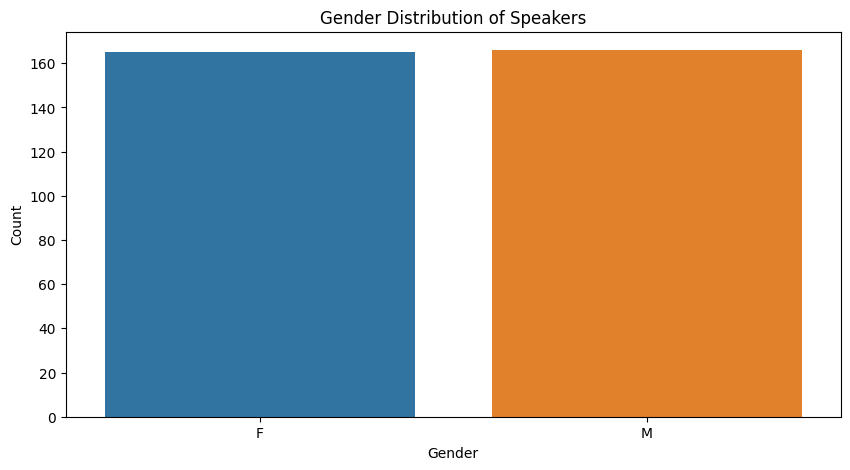

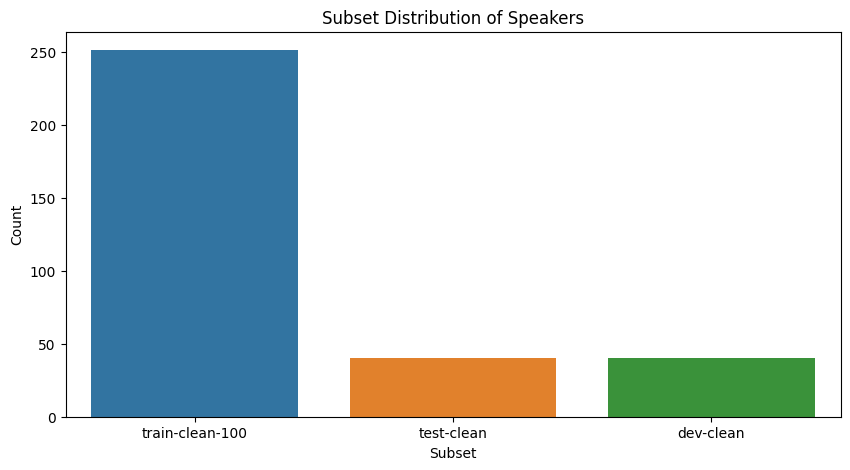

In [3]:
# Gender Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=speakers_df, x='gender')
plt.title("Gender Distribution of Speakers")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Subset Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=speakers_df, x='subset')
plt.title("Subset Distribution of Speakers")
plt.xlabel("Subset")
plt.ylabel("Count")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


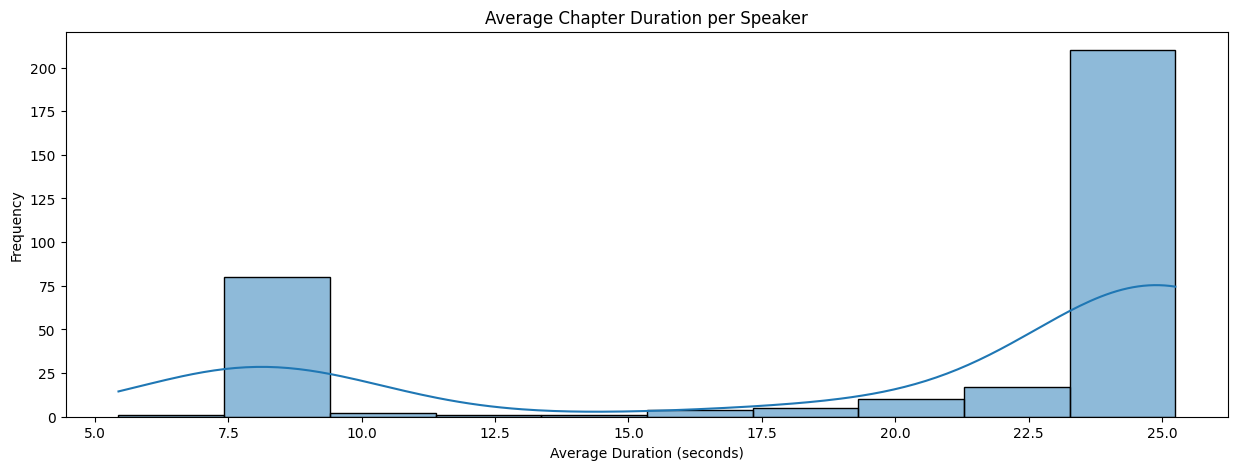

In [4]:
# Merge speakers with chapters for duration analysis
speaker_chapter_df = pd.merge(speakers_df, chapters_df, left_on='reader_id', right_on='reader_id')

# Calculate average chapter duration per speaker
avg_chapter_duration = speaker_chapter_df.groupby('reader_id')['duration_x'].mean()

# Plot
plt.figure(figsize=(15, 5))
sns.histplot(avg_chapter_duration, kde=True)
plt.title("Average Chapter Duration per Speaker")
plt.xlabel("Average Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


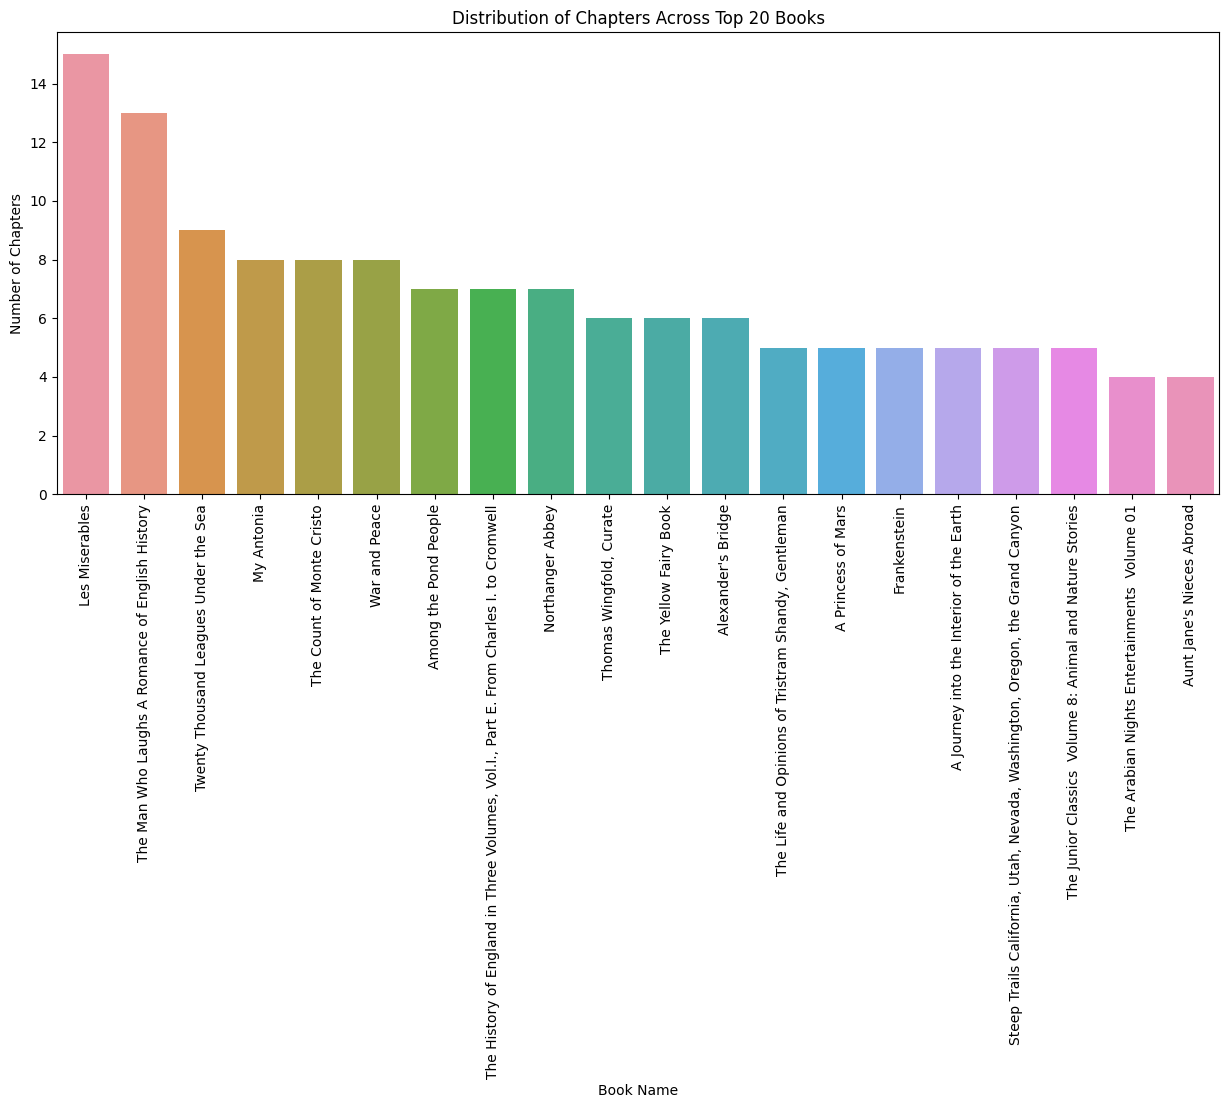

In [10]:
# Merge chapters_df with books_df to get book names
chapter_book_df = pd.merge(chapters_df, books_df, on='book_id')

# Select the top 20 books by chapter count
top_books = chapter_book_df['book_name'].value_counts().head(20).index

# Plot the distribution using book names
plt.figure(figsize=(15, 6))
sns.countplot(data=chapter_book_df[chapter_book_df['book_name'].isin(top_books)], 
              x='book_name', order=top_books)
plt.title("Distribution of Chapters Across Top 20 Books")
plt.xlabel("Book Name")
plt.ylabel("Number of Chapters")
plt.xticks(rotation=90)
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


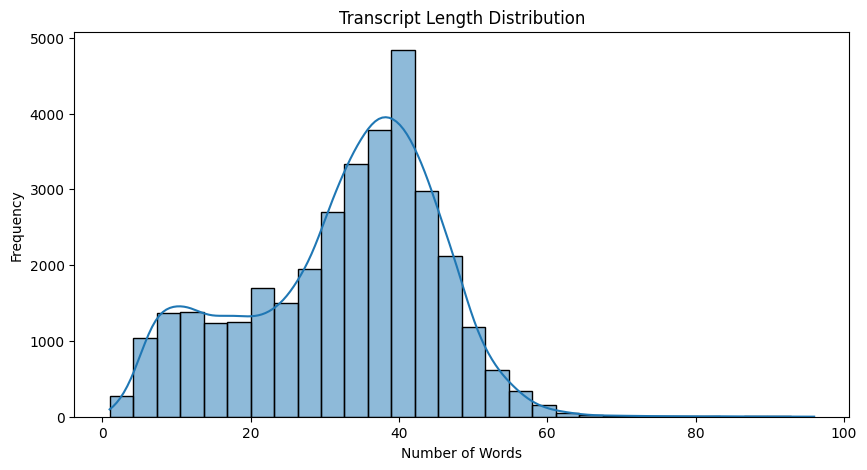

In [6]:
# Add transcript lengths to utterances DataFrame
utterances_df['transcript_length'] = utterances_df['transcript'].apply(lambda x: len(str(x).split()))

# Plot histogram of transcript lengths
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['transcript_length'], bins=30, kde=True)
plt.title("Transcript Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


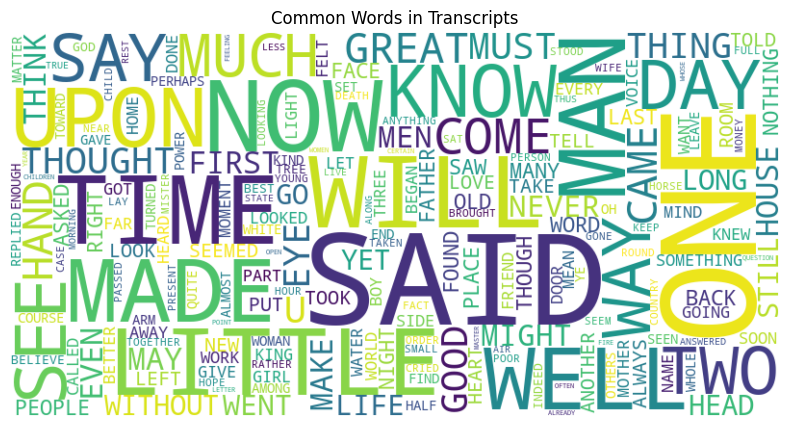

In [7]:
# Concatenate all transcripts for word cloud
text = " ".join(utterances_df['transcript'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Transcripts")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


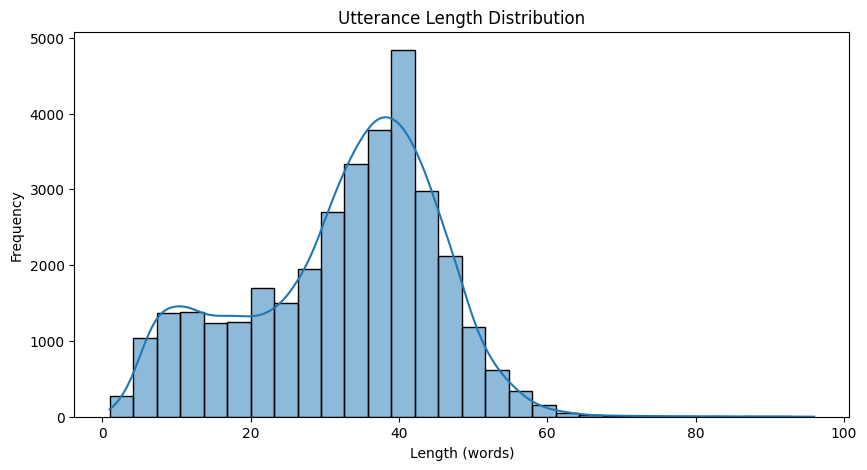

In [8]:
# Plot utterance lengths
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['transcript_length'], bins=30, kde=True)
plt.title("Utterance Length Distribution")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.show()


# 
audio

  0%|                                                                                        | 0/33862 [00:00<?, ?it/s]C:\Users\rosha\AppData\Local\Temp\ipykernel_6488\418742757.py:11: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  return librosa.get_duration(filename=file_path)
100%|████████████████████████████████████████████████████████████████████████████| 33862/33862 [09:41<00:00, 58.24it/s]
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Minimum audio duration: 1.285 seconds
Maximum audio duration: 34.955 seconds


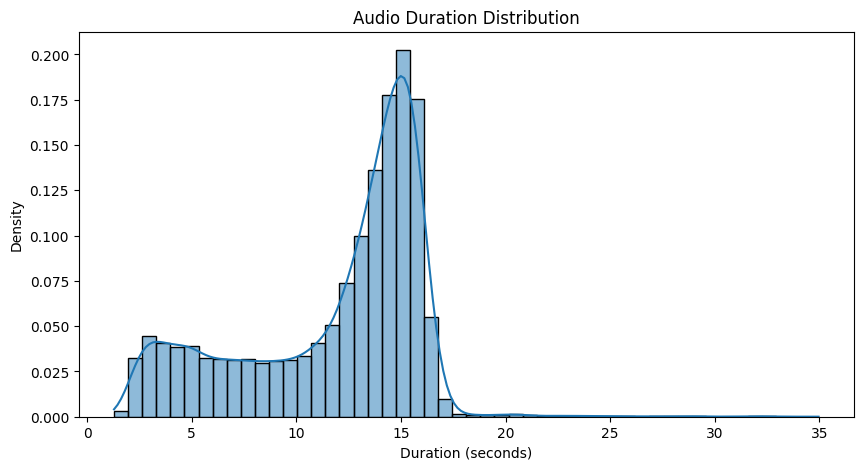

In [9]:
import librosa
import pandas as pd
import concurrent.futures
from tqdm import tqdm  # for progress tracking
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get the duration of an audio file
def get_audio_duration(file_path):
    try:
        return librosa.get_duration(filename=file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process audio files in parallel with limited concurrency
def calculate_durations_parallel(file_paths, max_workers=10):
    durations = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Using tqdm to show progress
        for duration in tqdm(executor.map(get_audio_duration, file_paths), total=len(file_paths)):
            durations.append(duration)
    return durations

# Apply the parallel processing function
utterances_df['audio_duration'] = calculate_durations_parallel(utterances_df['file_path'].tolist(), max_workers=10)

# Remove any None values (in case of errors in processing)
utterances_df = utterances_df.dropna(subset=['audio_duration'])

# Find min and max duration
min_duration = utterances_df['audio_duration'].min()
max_duration = utterances_df['audio_duration'].max()

print(f"Minimum audio duration: {min_duration} seconds")
print(f"Maximum audio duration: {max_duration} seconds")

# Plot distribution of audio durations with density normalization
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['audio_duration'], bins=50, kde=True, stat="density")  # Higher bin count and density
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Density")
plt.show()


Processing audio files: 100%|██████████████████████████████████████████████████████| 5000/5000 [05:19<00:00, 15.64it/s]


          mel_mean  mel_variance
count  5000.000000   5000.000000
mean    -52.262798    265.142609
std       4.670892     55.194519
min     -67.125526    117.779533
25%     -55.459785    227.330360
50%     -52.595716    263.502304
75%     -49.205208    302.705551
max     -37.156200    477.516693


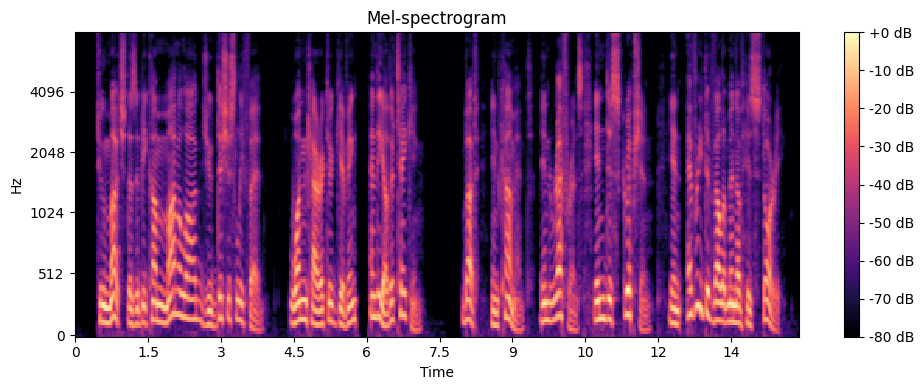

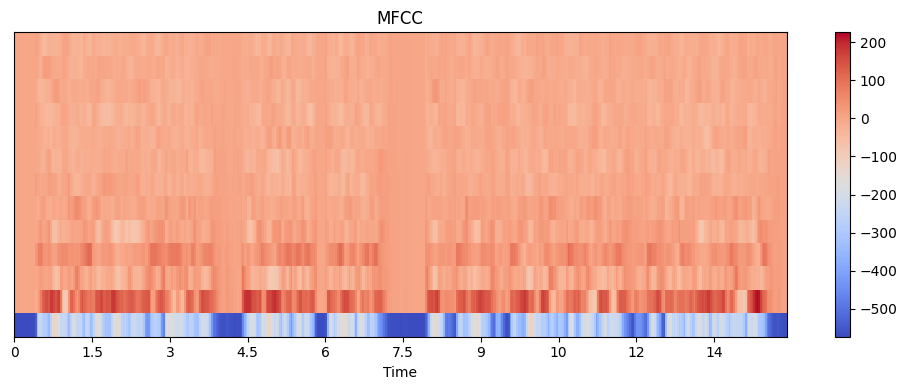

In [8]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import librosa.display  # Import display module to visualize spectrograms

# Select a random sample of 5 audio files from the DataFrame
sample_files = random.sample(utterances_df['file_path'].tolist(), 5000)

# Function to extract audio features and summary statistics
def extract_audio_features_summary(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_mean = np.mean(mel_spec_db)
        mel_variance = np.var(mel_spec_db)

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_variance = np.var(mfccs, axis=1)

        return {
            'file_path': file_path,
            'mel_spec_db': mel_spec_db,  # Full matrix
            'mfccs': mfccs,              # Full matrix
            'mel_mean': mel_mean,
            'mel_variance': mel_variance,
            'mfccs_mean': mfccs_mean,
            'mfccs_variance': mfccs_variance,
            'sr': sr  # Return the sample rate for plotting
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Sequential processing of audio files
audio_features_summary = []
for file_path in tqdm(sample_files, desc="Processing audio files"):
    result = extract_audio_features_summary(file_path)
    if result:
        audio_features_summary.append(result)

# Check if any features were extracted
if not audio_features_summary:
    print("No audio features were extracted. There may be an issue with file processing.")
else:
    # Create a DataFrame from the extracted summaries
    summary_df = pd.DataFrame([
        {
            'file_path': result['file_path'],
            'mel_mean': result['mel_mean'],
            'mel_variance': result['mel_variance'],
            'mfccs_mean': result['mfccs_mean'],
            'mfccs_variance': result['mfccs_variance']
        }
        for result in audio_features_summary
    ])

    # Inspect summary statistics (mean and variance of Mel-spectrogram and MFCCs)
    print(summary_df[['mel_mean', 'mel_variance']].describe())

    # Plot Mel-spectrogram and MFCCs for the first audio file in the sample
    first_file = audio_features_summary[0]
    sr = first_file['sr']  # Retrieve the sample rate from the first file

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(first_file['mel_spec_db'], sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(first_file['mfccs'], sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()


C:\Users\rosha\AppData\Local\Temp\ipykernel_3904\4143321647.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
C:\Users\rosha\AppData\Roaming\Python\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file T:\paper dataset\train-clean-100\LibriSpeech\train-clean-100\7367\86737\7367-86737-0107.flac: 


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


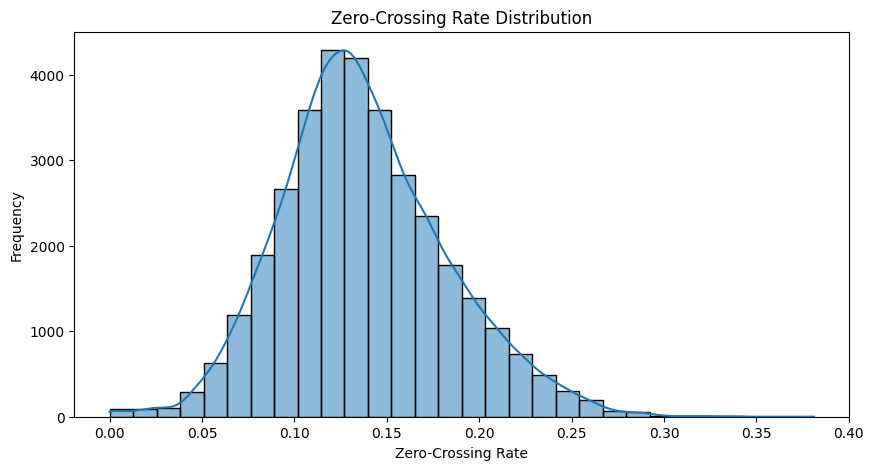

In [9]:
def get_zero_crossing_rate(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) == 0:
            return None  # Skip silent files
        zero_crossings = librosa.zero_crossings(y, pad=False)
        return sum(zero_crossings) / len(y)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Calculate zero-crossing rate
utterances_df['zero_crossing_rate'] = utterances_df['file_path'].apply(get_zero_crossing_rate)

# Drop any rows with None values in zero_crossing_rate
utterances_df.dropna(subset=['zero_crossing_rate'], inplace=True)

# Plot Zero-Crossing Rate Distribution
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['zero_crossing_rate'], bins=30, kde=True)
plt.title("Zero-Crossing Rate Distribution")
plt.xlabel("Zero-Crossing Rate")
plt.ylabel("Frequency")
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rosha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


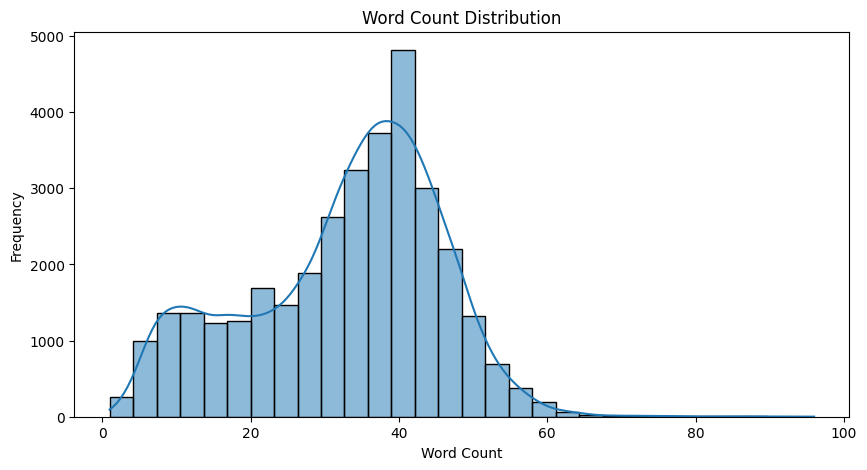

In [10]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

def text_statistics(transcript):
    words = word_tokenize(transcript)
    sentences = sent_tokenize(transcript)
    word_count = len(words)
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count
    return pd.Series([word_count, sentence_count, avg_word_length])

utterances_df[['word_count', 'sentence_count', 'avg_word_length']] = utterances_df['transcript'].apply(text_statistics)

# Visualize Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['word_count'], bins=30, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


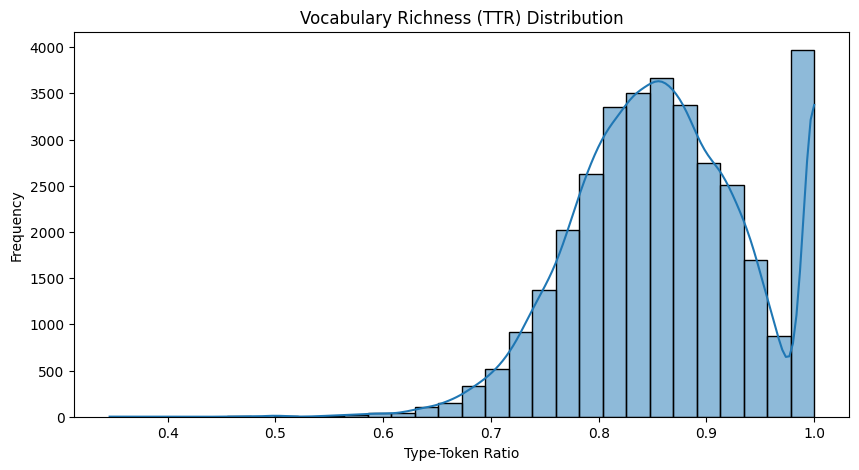

In [11]:
def vocabulary_richness(transcript):
    words = word_tokenize(transcript)
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

utterances_df['vocabulary_richness'] = utterances_df['transcript'].apply(vocabulary_richness)

# Visualize Vocabulary Richness
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['vocabulary_richness'], bins=30, kde=True)
plt.title("Vocabulary Richness (TTR) Distribution")
plt.xlabel("Type-Token Ratio")
plt.ylabel("Frequency")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


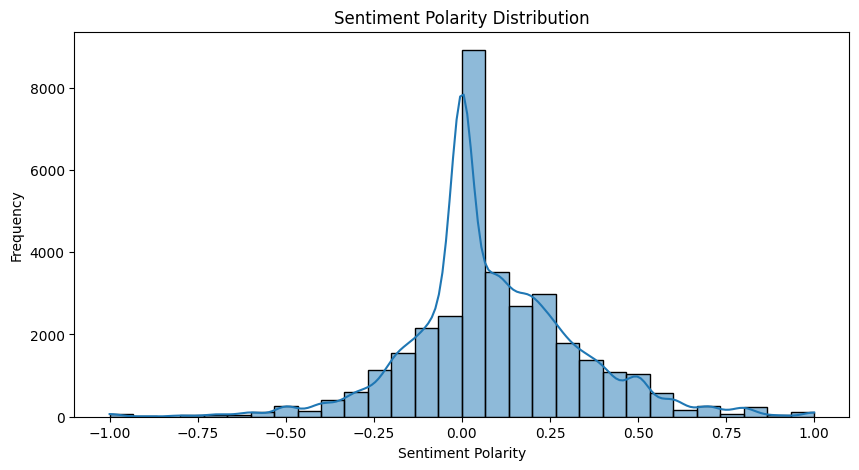

In [18]:
from textblob import TextBlob

def get_sentiment(transcript):
    blob = TextBlob(transcript)
    return blob.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

utterances_df['sentiment'] = utterances_df['transcript'].apply(get_sentiment)

# Plot Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rosha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rosha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


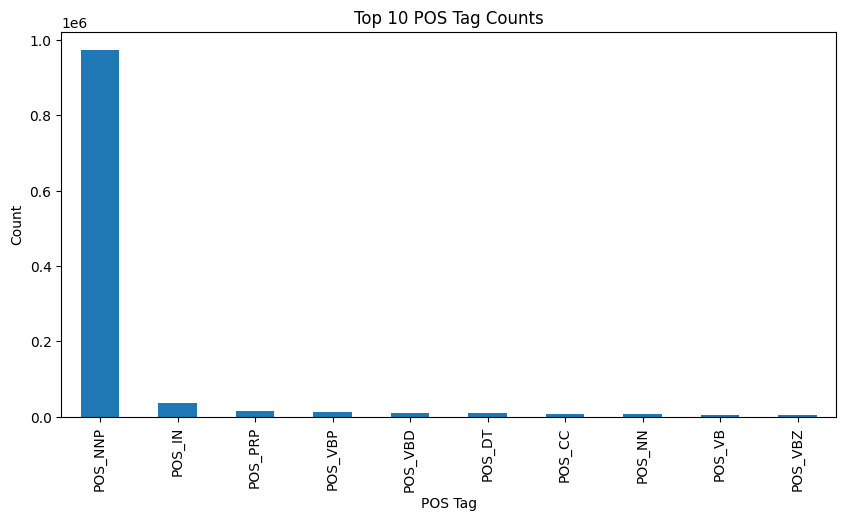

In [23]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Define POS distribution function
def pos_distribution(transcript):
    words = word_tokenize(transcript)
    pos_tags = pos_tag(words)
    pos_counts = nltk.FreqDist(tag for (word, tag) in pos_tags)
    return pd.Series({tag: pos_counts[tag] for tag in pos_counts})

# Apply POS distribution analysis
pos_df = utterances_df['transcript'].apply(pos_distribution).fillna(0)
pos_df = pos_df.add_prefix('POS_')
utterances_df = pd.concat([utterances_df, pos_df], axis=1)

# Visualize POS Distribution for the most common tags
pos_df.sum().nlargest(10).plot(kind='bar', figsize=(10, 5))
plt.title("Top 10 POS Tag Counts")
plt.xlabel("POS Tag")
plt.ylabel("Count")
plt.show()


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(utterances_df['transcript'])

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Display the top words in each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #1:
['went', 'door', 'way', 'eyes', 'don', 'came', 'come', 'like', 'little', 'said']
Topic #2:
['nature', 'people', 'king', 'world', 'human', 'great', 'god', 'man', 'love', 'said']
Topic #3:
['feet', 'far', 'life', 'time', 'man', 'water', 'men', 'great', 'like', 'little']
Topic #4:
['miss', 'day', 'thou', 'make', 'said', 'man', 'long', 'mister', 'did', 'time']
Topic #5:
['little', 'day', 'say', 'mister', 'think', 'know', 'did', 'man', 'old', 'said']


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 10 bigrams
bigrams = get_top_ngrams(utterances_df['transcript'], n=10, ngram_range=(2, 2))
print("Top 10 Bigrams:", bigrams)

# Top 10 trigrams
trigrams = get_top_ngrams(utterances_df['transcript'], n=10, ngram_range=(3, 3))
print("Top 10 Trigrams:", trigrams)


Top 10 Bigrams: [('young man', 190), ('old man', 172), ('don know', 138), ('uncle john', 115), ('did know', 92), ('new york', 90), ('uncle toby', 87), ('said mister', 85), ('old woman', 77), ('long time', 76)]
Top 10 Trigrams: [('master meadow mouse', 25), ('said uncle toby', 20), ('said uncle john', 16), ('tramp tramp tramp', 16), ('old mother nature', 15), ('knit make knit', 15), ('farmer brown boy', 14), ('said jimmie dale', 13), ('little bo peep', 13), ('monsieur le baron', 12)]


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
tfidf_matrix = tfidf.fit_transform(utterances_df['transcript'])

# Display top TF-IDF words for the first transcript
feature_names = tfidf.get_feature_names_out()
dense = tfidf_matrix.todense()
episode = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(episode)), episode) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

print("Top TF-IDF words for the first transcript:")
for phrase, score in sorted_phrase_scores[:10]:
    print(f"{feature_names[phrase]}: {score}")


Top TF-IDF words for the first transcript:
lynde: 0.43764783283718106
rachel: 0.3682882895948227
alders: 0.2779329359343579
missus: 0.2632010777960487
dipped: 0.25154698701684125
fringed: 0.25154698701684125
traversed: 0.23126926363950856
avonlea: 0.22689723236220885
brook: 0.2151074410352356
hollow: 0.19779486222392254


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


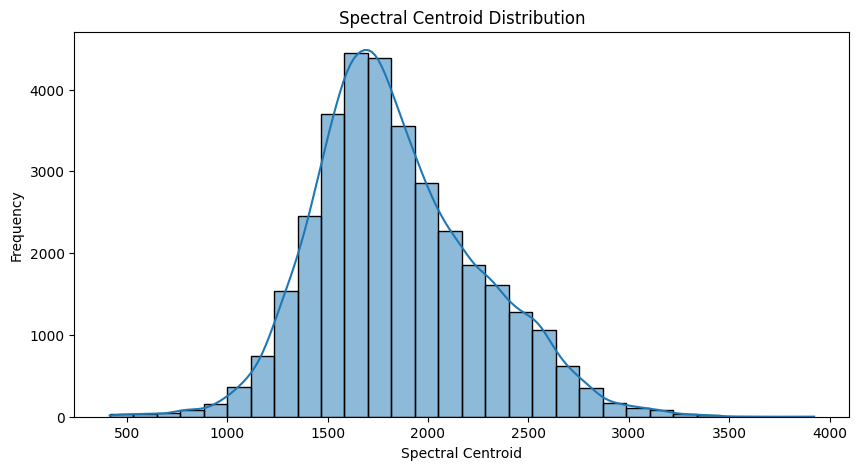

In [13]:
def get_spectral_centroid(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(spectral_centroid)

utterances_df['spectral_centroid'] = utterances_df['file_path'].apply(get_spectral_centroid)

# Plot Spectral Centroid
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['spectral_centroid'], bins=30, kde=True)
plt.title("Spectral Centroid Distribution")
plt.xlabel("Spectral Centroid")
plt.ylabel("Frequency")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


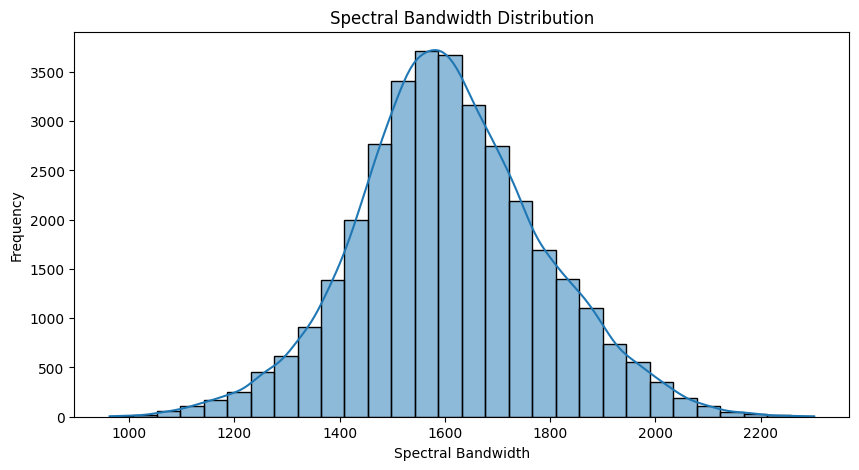

In [14]:
def get_spectral_bandwidth(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    return np.mean(spectral_bandwidth)

utterances_df['spectral_bandwidth'] = utterances_df['file_path'].apply(get_spectral_bandwidth)

# Plot Spectral Bandwidth
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['spectral_bandwidth'], bins=30, kde=True)
plt.title("Spectral Bandwidth Distribution")
plt.xlabel("Spectral Bandwidth")
plt.ylabel("Frequency")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


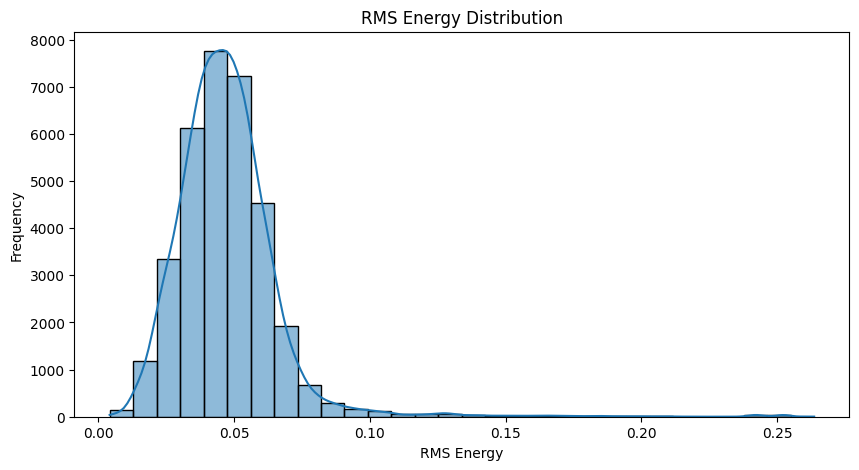

In [16]:
def get_rms(file_path):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)
    return np.mean(rms)

utterances_df['rms'] = utterances_df['file_path'].apply(get_rms)

# Plot RMS Energy
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['rms'], bins=30, kde=True)
plt.title("RMS Energy Distribution")
plt.xlabel("RMS Energy")
plt.ylabel("Frequency")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


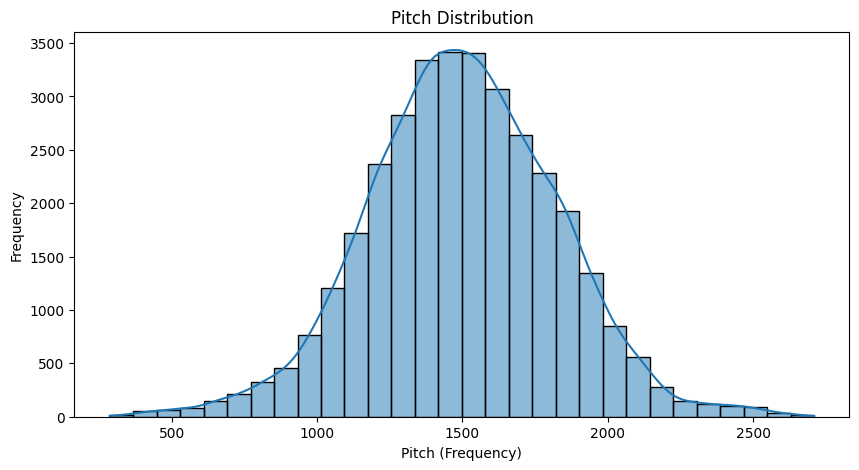

In [17]:
def get_pitch(file_path):
    y, sr = librosa.load(file_path, sr=None)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])  # Ignoring zero-pitched (unvoiced) frames
    return pitch_mean

utterances_df['pitch'] = utterances_df['file_path'].apply(get_pitch)

# Plot Pitch
plt.figure(figsize=(10, 5))
sns.histplot(utterances_df['pitch'], bins=30, kde=True)
plt.title("Pitch Distribution")
plt.xlabel("Pitch (Frequency)")
plt.ylabel("Frequency")
plt.show()


# feature engineering

#    
BOOKS AND SPEAKERS

In [33]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect("T:/paper dataset/librispeech_metadata.db")

# Load the necessary tables
utterances_df = pd.read_sql_query("SELECT * FROM utterances", conn)
speakers_df = pd.read_sql_query("SELECT * FROM speakers", conn)
chapters_df = pd.read_sql_query("SELECT * FROM chapters", conn)
books_df = pd.read_sql_query("SELECT * FROM books", conn)

# Merge the `utterances` and `chapters` tables to access `book_id` and `duration` for each utterance
utterances_chapters_df = pd.merge(utterances_df, chapters_df, left_on=['speaker_id', 'chapter_id'], right_on=['reader_id', 'chapter_id'], how='left')

# Calculate reading duration for each speaker (sum of chapter durations)
speaker_durations = speakers_df[['reader_id', 'duration']].groupby('reader_id').sum().reset_index()
speaker_durations.columns = ['speaker_id', 'total_duration']

# Count unique books and chapters read by each speaker
unique_books_per_speaker = utterances_chapters_df.groupby('speaker_id')['book_id'].nunique().reset_index()
unique_books_per_speaker.columns = ['speaker_id', 'unique_books']

unique_chapters_per_speaker = utterances_chapters_df.groupby('speaker_id')['chapter_id'].nunique().reset_index()
unique_chapters_per_speaker.columns = ['speaker_id', 'unique_chapters']

# Calculate average audio length for each speaker based on chapter durations
avg_audio_length_per_speaker = utterances_chapters_df.groupby('speaker_id')['duration'].mean().reset_index()
avg_audio_length_per_speaker.columns = ['speaker_id', 'avg_duration']

# Combine aggregates for each speaker
speaker_aggregates = (speaker_durations
                      .merge(unique_books_per_speaker, on='speaker_id', how='left')
                      .merge(unique_chapters_per_speaker, on='speaker_id', how='left')
                      .merge(avg_audio_length_per_speaker, on='speaker_id', how='left'))

# Display speaker aggregates
print("Speaker Aggregates:")
print(speaker_aggregates.head())

# Calculate book-level aggregates
# Sum of durations for each book
book_durations = chapters_df.groupby('book_id')['duration'].sum().reset_index()
book_durations.columns = ['book_id', 'total_duration']

# Count unique chapters for each book
unique_chapters_per_book = chapters_df.groupby('book_id')['chapter_id'].nunique().reset_index()
unique_chapters_per_book.columns = ['book_id', 'unique_chapters']

# Calculate average audio length for each book based on chapter durations
avg_audio_length_per_book = chapters_df.groupby('book_id')['duration'].mean().reset_index()
avg_audio_length_per_book.columns = ['book_id', 'avg_duration']

# Combine aggregates for each book
book_aggregates = (book_durations
                   .merge(unique_chapters_per_book, on='book_id', how='left')
                   .merge(avg_audio_length_per_book, on='book_id', how='left')
                   .merge(books_df[['book_id', 'book_name', 'author']], on='book_id', how='left'))

# Display book aggregates
print("Book Aggregates:")
print(book_aggregates.head())

# Close the connection
conn.close()


Speaker Aggregates:
   speaker_id  total_duration  unique_books  unique_chapters  avg_duration
0          19           25.19             1                2     13.911441
1          26           25.08             1                2     16.217288
2          27           20.14             2                2      9.732319
3          32           24.01             2                4      7.873077
4          39           25.05             1                3      8.927073
Book Aggregates:
   book_id  total_duration  unique_chapters  avg_duration  \
0       11            1.76                1      1.760000   
1       16           15.70                1     15.700000   
2       24            5.25                2      2.625000   
3       33            8.07                2      4.035000   
4       45           41.17                3     13.723333   

                          book_name author  
0  Alice's Adventures in Wonderland         
1                         Peter Pan         
2          

# 
text

In [34]:
# Count unique chapters
num_chapters = utterances_df['chapter_id'].nunique()
print(f"Number of unique chapters: {num_chapters}")


Number of unique chapters: 769


In [35]:
# Count chapters per speaker
chapters_per_speaker = utterances_df.groupby('speaker_id')['chapter_id'].nunique().reset_index()
chapters_per_speaker.columns = ['speaker_id', 'num_chapters']
print(chapters_per_speaker)


     speaker_id  num_chapters
0            19             2
1            26             2
2            27             2
3            32             4
4            39             3
..          ...           ...
326        8770             3
327        8797             1
328        8838             2
329        8842             4
330        8975             1

[331 rows x 2 columns]


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# Sample DataFrame `utterances_df` to simulate the structure - replace with your data
# Assuming utterances_df is already created and contains 'chapter_id' and 'transcript' columns.

# Concatenate all transcripts into one per chapter
transcripts_df = utterances_df.groupby('chapter_id')['transcript'].apply(lambda x: ' '.join(x)).reset_index()

# Extract TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(transcripts_df['transcript'])

# Define different values of `n_components` to test
n_components_values = [5, 10, 15]

# Dictionary to store topics for each value of `n_components`
all_topics = {}

# Loop through each value of `n_components` to fit NMF and extract topics
for n in n_components_values:
    print(f"\nTesting with n_components = {n}")
    nmf = NMF(n_components=n, random_state=1)
    nmf_topics = nmf.fit_transform(tfidf)

    # Store top words for each topic in a list of dictionaries
    topic_words = {}
    for index, topic in enumerate(nmf.components_):
        words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
        topic_words[f"Topic {index+1}"] = words

        # Print each topic's top words
        print(f"Topic #{index+1}: {words}")
    
    # Save the topic words for the current n_components
    all_topics[f'n_components_{n}'] = topic_words

# Optional: Convert all topics to a DataFrame for easy viewing or saving
# This will save each `n_components` setting and associated topics in a structured format
all_topics_df = pd.DataFrame({k: pd.Series(v) for k, v in all_topics.items()})
print("\nAll topics for each n_components setting:")
print(all_topics_df)

# Save topics to a file if needed
all_topics_df.to_csv('nmf_topics.csv', index=False)

# You can analyze `all_topics_df` to see which `n_components` value gives the best topic coherence.



Testing with n_components = 5


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Topic #1: ['night', 'went', 'king', 'like', 'old', 'said', 'came', 'little', 'water', 'princess']
Topic #2: ['war', 'years', 'general', 'man', 'great', 'power', 'people', 'eighteen', 'life', 'men']
Topic #3: ['little', 'sir', 'think', 'did', 'miss', 'don', 'know', 'missus', 'mister', 'said']
Topic #4: ['hast', 'said', 'god', 'hath', 'doth', 'heart', 'love', 'thee', 'thy', 'thou']
Topic #5: ['jane', 'said', 'beth', 'merrick', 'toby', 'louise', 'major', 'patsy', 'john', 'uncle']

Testing with n_components = 10
Topic #1: ['like', 'think', 'tell', 'old', 'man', 'little', 'know', 'did', 'don', 'said']
Topic #2: ['indians', 'miles', 'men', 'camp', 'captain', 'snow', 'feet', 'sea', 'river', 'water']
Topic #3: ['lady', 'jane', 'elizabeth', 'sir', 'rebecca', 'said', 'tom', 'miss', 'missus', 'mister']
Topic #4: ['art', 'toby', 'hast', 'hath', 'heart', 'doth', 'love', 'thee', 'thy', 'thou']
Topic #5: ['jane', 'said', 'beth', 'merrick', 'toby', 'louise', 'major', 'patsy', 'john', 'uncle']
Topic #6

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Topic #1: ['went', 'old', 'think', 'll', 'tell', 'did', 'little', 'know', 'don', 'said']
Topic #2: ['trail', 'mountain', 'feet', 'miles', 'valley', 'water', 'camp', 'indians', 'snow', 'river']
Topic #3: ['bingley', 'said', 'carlyle', 'elizabeth', 'sir', 'lady', 'isabel', 'miss', 'mister', 'missus']
Topic #4: ['art', 'toby', 'hast', 'hath', 'heart', 'doth', 'love', 'thee', 'thy', 'thou']
Topic #5: ['nieces', 'said', 'beth', 'merrick', 'toby', 'louise', 'major', 'patsy', 'john', 'uncle']
Topic #6: ['jason', 'majesty', 'said', 'dragon', 'florina', 'palace', 'queen', 'prince', 'princess', 'king']
Topic #7: ['didn', 'tree', 'rabbit', 'snake', 'old', 'robin', 'cresty', 'wren', 'jenny', 'peter']
Topic #8: ['new', 'church', 'years', 'great', 'government', 'power', 'eighteen', 'people', 'life', 'men']
Topic #9: ['miss', 'brother', 'father', 'allen', 'isabella', 'thorpe', 'morland', 'henry', 'tilney', 'catherine']
Topic #10: ['death', 'light', 'voice', 'head', 'like', 'face', 'room', 'door', 'ey

#  
n = 10

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# Concatenate all transcripts into one per chapter
transcripts_df = utterances_df.groupby('chapter_id')['transcript'].apply(lambda x: ' '.join(x)).reset_index()

# Extract TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(transcripts_df['transcript'])

# Set final n_components
final_n_components = 10

# Topic modeling using NMF with finalized `n_components`
nmf = NMF(n_components=final_n_components, random_state=1)
nmf_topics = nmf.fit_transform(tfidf)

# Display and save top keywords for each topic
final_topic_words = {}
for index, topic in enumerate(nmf.components_):
    words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    final_topic_words[f"Topic {index+1}"] = words
    print(f"Topic #{index+1}: {words}")

# Convert to DataFrame for easy viewing and saving
final_topics_df = pd.DataFrame(final_topic_words)
final_topics_df.to_csv('final_nmf_topics.csv', index=False)
print("\nFinal topics saved to 'final_nmf_topics.csv'")


Topic #1: ['like', 'think', 'tell', 'old', 'man', 'little', 'know', 'did', 'don', 'said']
Topic #2: ['indians', 'miles', 'men', 'camp', 'captain', 'snow', 'feet', 'sea', 'river', 'water']
Topic #3: ['lady', 'jane', 'elizabeth', 'sir', 'rebecca', 'said', 'tom', 'miss', 'missus', 'mister']
Topic #4: ['art', 'toby', 'hast', 'hath', 'heart', 'doth', 'love', 'thee', 'thy', 'thou']
Topic #5: ['jane', 'said', 'beth', 'merrick', 'toby', 'louise', 'major', 'patsy', 'john', 'uncle']
Topic #6: ['jason', 'majesty', 'dragon', 'florina', 'said', 'palace', 'queen', 'prince', 'princess', 'king']
Topic #7: ['orchard', 'snake', 'didn', 'robin', 'old', 'tree', 'cresty', 'wren', 'jenny', 'peter']
Topic #8: ['state', 'years', 'nature', 'great', 'man', 'eighteen', 'people', 'power', 'men', 'life']
Topic #9: ['brother', 'allen', 'isabella', 'thorpe', 'eleanor', 'morland', 'henry', 'miss', 'tilney', 'catherine']
Topic #10: ['aramis', 'ah', 'baron', 'le', 'said', 'monsieur', 'madame', 'planchet', 'porthos', 'a

#  sentinemnt and tone analyis

In [11]:
import sqlite3
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Connect to your SQLite database
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Update with the actual path to your database
conn = sqlite3.connect(db_path)

# Load transcripts from the SQLite database
# Assuming the transcripts are stored in a table called `utterances` with a `transcript` column
transcripts_df = pd.read_sql_query("SELECT utterance_id, transcript FROM utterances", conn)

# Function to extract sentiment and VADER scores
def calculate_features(text):
    # TextBlob sentiment
    blob = TextBlob(text)
    polarity, subjectivity = blob.sentiment.polarity, blob.sentiment.subjectivity
    
    # VADER sentiment
    vader_scores = analyzer.polarity_scores(text)
    
    # Create the results as a dictionary
    return pd.Series({
        'polarity': polarity,
        'subjectivity': subjectivity,
        'vader_neg': vader_scores['neg'],
        'vader_neu': vader_scores['neu'],
        'vader_pos': vader_scores['pos'],
        'vader_compound': vader_scores['compound']
    })

# Apply the calculate_features function to each transcript in the DataFrame
transcripts_df = transcripts_df.join(transcripts_df['transcript'].apply(calculate_features))

# Display the DataFrame with the calculated features
print(transcripts_df.head())

# Close the database connection
conn.close()


    utterance_id                                         transcript  polarity  \
0  103-1240-0000  CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M... -0.035278   
1  103-1240-0001  THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ... -0.048214   
2  103-1240-0002  FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC... -0.100000   
3  103-1240-0003  AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...  0.216667   
4  103-1240-0004  BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...  0.293750   

   subjectivity  vader_neg  vader_neu  vader_pos  vader_compound  
0      0.414444      0.000      0.946      0.054          0.2263  
1      0.283333      0.000      0.900      0.100          0.5499  
2      0.468750      0.000      1.000      0.000          0.0000  
3      0.625000      0.094      0.906      0.000         -0.6124  
4      0.568750      0.000      0.825      0.175          0.8047  


In [8]:
# Reconnect to your SQLite database
conn = sqlite3.connect(db_path)

# Check data in the new `sentiment_analysis` table
query = "SELECT * FROM utterances LIMIT 5"
sentiment_df = pd.read_sql_query(query, conn)
print(sentiment_df)

# Close the connection
conn.close()


    utterance_id  speaker_id  chapter_id  \
0  103-1240-0000         103        1240   
1  103-1240-0001         103        1240   
2  103-1240-0002         103        1240   
3  103-1240-0003         103        1240   
4  103-1240-0004         103        1240   

                                           file_path  \
0  T:\paper dataset\train-clean-100\LibriSpeech\t...   
1  T:\paper dataset\train-clean-100\LibriSpeech\t...   
2  T:\paper dataset\train-clean-100\LibriSpeech\t...   
3  T:\paper dataset\train-clean-100\LibriSpeech\t...   
4  T:\paper dataset\train-clean-100\LibriSpeech\t...   

                                          transcript  polarity  subjectivity  \
0  CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M... -0.035278      0.414444   
1  THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ... -0.048214      0.283333   
2  FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC... -0.100000      0.468750   
3  AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...  0.216667      0.625000  

In [9]:
import sqlite3

# Connect to the database
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Update with the actual path
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# List of ALTER TABLE statements to add each column
alter_table_statements = [
    "ALTER TABLE utterances ADD COLUMN polarity REAL",
    "ALTER TABLE utterances ADD COLUMN subjectivity REAL",
    "ALTER TABLE utterances ADD COLUMN vader_neg REAL",
    "ALTER TABLE utterances ADD COLUMN vader_neu REAL",
    "ALTER TABLE utterances ADD COLUMN vader_pos REAL",
    "ALTER TABLE utterances ADD COLUMN vader_compound REAL"
]

# Execute each statement
for statement in alter_table_statements:
    try:
        cursor.execute(statement)
    except sqlite3.OperationalError as e:
        print(f"Error: {e}")  # This will print an error if the column already exists

# Commit the changes and close the connection
conn.commit()
conn.close()


In [12]:
# Reconnect to the database to store the sentiment analysis results
conn = sqlite3.connect(db_path)

# Update the existing utterances table with sentiment analysis results
for _, row in transcripts_df.iterrows():
    conn.execute(
        '''
        UPDATE utterances
        SET polarity = ?, subjectivity = ?, vader_neg = ?, vader_neu = ?, vader_pos = ?, vader_compound = ?
        WHERE utterance_id = ?
        ''',
        (row['polarity'], row['subjectivity'], row['vader_neg'], row['vader_neu'], row['vader_pos'], row['vader_compound'], row['utterance_id'])
    )
conn.commit()
conn.close()
print("Sentiment analysis results updated in the 'utterances' table.")


Sentiment analysis results updated in the 'utterances' table.


In [14]:
import sqlite3
import pandas as pd

# Reconnect to your SQLite database
conn = sqlite3.connect(db_path)

# Check if the sentiment columns have data in the `utterances` table
query = "SELECT utterance_id, transcript, polarity, subjectivity, vader_neg, vader_neu, vader_pos, vader_compound FROM utterances LIMIT 5"
results_df = pd.read_sql_query(query, conn)
print(results_df)

# Close the connection
conn.close()


    utterance_id                                         transcript  polarity  \
0  103-1240-0000  CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M... -0.035278   
1  103-1240-0001  THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ... -0.048214   
2  103-1240-0002  FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC... -0.100000   
3  103-1240-0003  AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...  0.216667   
4  103-1240-0004  BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...  0.293750   

   subjectivity  vader_neg  vader_neu  vader_pos  vader_compound  
0      0.414444      0.000      0.946      0.054          0.2263  
1      0.283333      0.000      0.900      0.100          0.5499  
2      0.468750      0.000      1.000      0.000          0.0000  
3      0.625000      0.094      0.906      0.000         -0.6124  
4      0.568750      0.000      0.825      0.175          0.8047  


In [9]:
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

# Connect to your SQLite database
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Update with the actual path to your database
conn = sqlite3.connect(db_path)

# Load transcripts from the SQLite database
transcripts_df = pd.read_sql_query("SELECT utterance_id, transcript FROM utterances", conn)

# Preprocess the transcripts by removing special characters and lowercasing
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

transcripts_df['cleaned_transcript'] = transcripts_df['transcript'].apply(preprocess_text)

# Use CountVectorizer to create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dt_matrix = vectorizer.fit_transform(transcripts_df['cleaned_transcript'])

# Initialize LDA model
n_topics = 10  # Adjust based on the variety of themes you expect
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(dt_matrix)

# Extract topic keywords
def get_topics(model, feature_names, num_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-num_top_words:]]
        topics[f"Topic {idx+1}"] = top_words
    return topics

# Get the top keywords for each topic
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = get_topics(lda_model, feature_names, num_top_words)

# Print topics and their top words
for topic, keywords in topics.items():
    print(f"{topic}: {', '.join(keywords)}")

# Close the database connection
conn.close()


Topic 1: old, like, say, house, great, woman, man, young, know, said
Topic 2: good, night, green, like, did, way, day, time, just, little
Topic 3: black, people, man, little, white, life, great, long, time, came
Topic 4: city, death, night, army, shall, men, went, great, day, way
Topic 5: day, come, think, eyes, old, went, little, face, did, said
Topic 6: asked, come, know, little, hand, time, man, did, old, said
Topic 7: years, world, day, make, little, water, country, said, man, like
Topic 8: power, life, time, words, state, day, new, heart, men, great
Topic 9: time, tell, did, think, know, little, like, dont, mister, said
Topic 10: time, said, did, thought, believe, mister, like, missus, miss, man


In [ ]:
import sqlite3
import pandas as pd
import librosa
import numpy as np
import os

# Connect to SQLite database and fetch the file paths for the audio files
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Update with the actual path to your database
conn = sqlite3.connect(db_path)

# Load file paths from the database
audio_files_df = pd.read_sql_query("SELECT utterance_id, file_path FROM utterances", conn)

# Function to extract audio features
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Zero Crossing Rate
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y).squeeze())
        
        # Pitch (using librosa's piptrack function for pitch estimation)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch = np.mean(pitches[pitches > 0]) if pitches[pitches > 0].size > 0 else 0
        
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Spectral Centroid
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).squeeze())
        
        # Root Mean Square (RMS) energy
        rms = np.mean(librosa.feature.rms(y=y).squeeze())
        
        return pd.Series({
            'zero_crossing_rate': zero_crossing_rate,
            'pitch': pitch,
            'tempo': tempo,
            'spectral_centroid': spectral_centroid,
            'rms': rms
        })
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return pd.Series({
            'zero_crossing_rate': None,
            'pitch': None,
            'tempo': None,
            'spectral_centroid': None,
            'rms': None
        })

# Apply feature extraction on each audio file and store the results in the DataFrame
audio_features_df = audio_files_df['file_path'].apply(lambda x: extract_audio_features(x))

# Concatenate the original DataFrame with the extracted features
audio_files_df = pd.concat([audio_files_df, audio_features_df], axis=1)

# Display the DataFrame with extracted features
print(audio_files_df.head())

# Optionally save the extracted features back to the SQLite database
audio_files_df.to_sql('audio_features', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()


In [ ]:
import sqlite3
import pandas as pd
import librosa
import numpy as np
import os

# Path to the SQLite database
db_path = r"T:\paper dataset\librispeech_metadata.db"  # Update with your actual database path
conn = sqlite3.connect(db_path)

# Load file paths from the database
audio_files_df = pd.read_sql_query("SELECT utterance_id, file_path FROM utterances", conn)

# Function to extract audio features
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Zero Crossing Rate
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y).squeeze())
        
        # Pitch (using librosa's piptrack function for pitch estimation)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch = np.mean(pitches[pitches > 0]) if pitches[pitches > 0].size > 0 else 0
        
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Spectral Centroid
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).squeeze())
        
        # Root Mean Square (RMS) energy
        rms = np.mean(librosa.feature.rms(y=y).squeeze())
        
        return pd.Series({
            'zero_crossing_rate': zero_crossing_rate,
            'pitch': pitch,
            'tempo': tempo,
            'spectral_centroid': spectral_centroid,
            'rms': rms
        })
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return pd.Series({
            'zero_crossing_rate': None,
            'pitch': None,
            'tempo': None,
            'spectral_centroid': None,
            'rms': None
        })

# Apply feature extraction on each audio file and store the results in the DataFrame
audio_features_df = audio_files_df['file_path'].apply(lambda x: extract_audio_features(x))

# Concatenate the original DataFrame with the extracted features
audio_files_df = pd.concat([audio_files_df, audio_features_df], axis=1)

# Display the DataFrame with extracted features
print(audio_files_df.head())

# Define the table schema for audio features in the database
create_table_query = '''
CREATE TABLE IF NOT EXISTS audio_features (
    utterance_id TEXT PRIMARY KEY,
    file_path TEXT,
    zero_crossing_rate REAL,
    pitch REAL,
    tempo REAL,
    spectral_centroid REAL,
    rms REAL
)
'''

# Execute the query to create the table if it doesn't exist
conn.execute(create_table_query)

# Save extracted features to the audio_features table in the database
audio_files_df.to_sql('audio_features', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()


# content-filterning


In [1]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
db_path = r"T:\paper dataset\librispeech_metadata.db"
conn = sqlite3.connect(db_path)

# Load relevant data from the database
query = """
SELECT utterance_id, speaker_id, chapter_id, transcript, polarity, subjectivity,
       vader_neg, vader_neu, vader_pos, vader_compound, 
       zero_crossing_rate, pitch, tempo, spectral_centroid, rms
FROM utterances
"""
utterances_df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display a sample of the data
print(utterances_df.head())


    utterance_id  speaker_id  chapter_id  \
0  103-1240-0000         103        1240   
1  103-1240-0001         103        1240   
2  103-1240-0002         103        1240   
3  103-1240-0003         103        1240   
4  103-1240-0004         103        1240   

                                          transcript  polarity  subjectivity  \
0  CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M... -0.035278      0.414444   
1  THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ... -0.048214      0.283333   
2  FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC... -0.100000      0.468750   
3  AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...  0.216667      0.625000   
4  BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...  0.293750      0.568750   

   vader_neg  vader_neu  vader_pos  vader_compound  zero_crossing_rate  \
0      0.000      0.946      0.054          0.2263            0.120250   
1      0.000      0.900      0.100          0.5499            0.140934   
2      0.000      1.000      0.0

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming `utterances_df` already has the transcript features and audio features
# Select audio features
audio_features = utterances_df[['zero_crossing_rate', 'pitch', 'tempo', 'spectral_centroid', 'rms']]

# Handle NaNs in audio features by imputing with the mean
audio_features = audio_features.fillna(audio_features.mean())

# Rescale audio features
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

# Combine transcript features with topic features and sentiment features
features_df = pd.concat([
    utterances_df[['polarity', 'subjectivity', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']],
    topics_df
], axis=1)

# Scale the combined features
features_scaled = scaler.fit_transform(features_df)

# Combine scaled transcript and audio features
all_features = np.concatenate([
    features_scaled,
    audio_features_scaled
], axis=1)

# Calculate cosine similarity between utterances based on the combined features
similarity_matrix = cosine_similarity(all_features)

# Function to retrieve the most similar utterances
def get_similar_utterances(utterance_id, top_n=5):
    # Get the index of the specific utterance_id
    idx = utterances_df.index[utterances_df['utterance_id'] == utterance_id][0]
    
    # Get similarity scores for this utterance with all others
    similarity_scores = similarity_matrix[idx]
    
    # Get indices of top_n most similar utterances (excluding the utterance itself)
    similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
    
    # Retrieve similar utterances' IDs and similarity scores
    similar_utterances = [(utterances_df.iloc[i]['utterance_id'], similarity_scores[i]) for i in similar_indices]
    
    return similar_utterances

# Example usage
example_utterance_id = "103-1240-0001"
similar_utterances = get_similar_utterances(example_utterance_id, top_n=5)

# Display results
print(f"Similar utterances to {example_utterance_id}:\n", similar_utterances)


NameError: name 'topics_df' is not defined

In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Sample dataset structure (adjust as needed based on your data structure)
# Ensure your `transcripts_df` includes all relevant feature columns

# Example user profile with hypothetical preferences
user_profile = {
    'polarity': 0.2,
    'subjectivity': 0.4,
    'vader_neg': 0.1,
    'vader_neu': 0.5,
    'vader_pos': 0.4,
    'vader_compound': 0.3,
    'zero_crossing_rate': 0.13,
    'pitch': 1700,
    'tempo': 120,
    'spectral_centroid': 2200,
    'rms': 0.02,
    # Topic preferences (adjust weights as necessary)
    'topic_1': 0.5,
    'topic_2': 0.3,
    'topic_3': 0.1,
    'topic_4': 0.1,
    'topic_5': 0.0,
    'topic_6': 0.0,
    'topic_7': 0.0,
    'topic_8': 0.0,
    'topic_9': 0.0,
    'topic_10': 0.0,
}

# Convert user profile to a DataFrame for similarity calculation
user_profile_df = pd.DataFrame([user_profile])

# Define feature columns based on the transcript data
feature_columns = [
    'polarity', 'subjectivity', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'zero_crossing_rate', 'pitch', 'tempo', 'spectral_centroid', 'rms',
    'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 
    'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10'
]

# Extract only the feature columns for similarity calculation
transcript_features = transcripts_df[feature_columns]

# Calculate cosine similarity between user profile and transcript features
similarity_scores = cosine_similarity(user_profile_df, transcript_features)[0]

# Add similarity scores to the transcripts DataFrame
transcripts_df['similarity_score'] = similarity_scores

# Get top recommendations based on similarity score
top_recommendations = transcripts_df.sort_values(by='similarity_score', ascending=False).head(10)

# Display the top recommendations
print(top_recommendations[['utterance_id', 'similarity_score', 'file_path']])


NameError: name 'transcripts_df' is not defined

In [2]:
# Check if there are any NaN values in the original data
print("NaNs in features_df:", features_df.isna().sum().sum())
print("NaNs in audio_features:", audio_features.isna().sum().sum())

# Check after scaling
print("NaNs in features_scaled:", pd.DataFrame(features_scaled).isna().sum().sum())
print("NaNs in audio_features_scaled:", pd.DataFrame(audio_features_scaled).isna().sum().sum())

# Final check in all_features
print("NaNs in all_features:", all_features.isna().sum().sum())


NameError: name 'features_df' is not defined